<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Understanding-the-data" data-toc-modified-id="Understanding-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Understanding the data</a></span></li><li><span><a href="#Investigating-the-missing-data" data-toc-modified-id="Investigating-the-missing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Investigating the missing data</a></span></li><li><span><a href="#Distribution-of-the-data" data-toc-modified-id="Distribution-of-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Distribution of the data</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-sales-per-country" data-toc-modified-id="Distribution-of-sales-per-country-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distribution of sales per country</a></span></li><li><span><a href="#Shops-based-in-US" data-toc-modified-id="Shops-based-in-US-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Shops based in US</a></span></li></ul></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlation</a></span></li></ul></div>

## Description 

Using the Etsy Shops Dataset discover if there are particular attributes of the shops (e.g. location, number of reviews and followers) that may impact their success.

In [1]:
from string import ascii_letters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import cufflinks as cf
from ipywidgets import interact
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.express as px


cf.go_offline()

## Understanding the data

First, checking the dataset, printing some rows to understand the columns and information.

In [2]:
data = pd.read_csv('./data/etsy_shops_data.csv')
data.head()

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0,0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2,0,None
2,19-Nov,0,0,USD,True,False,-99,-99,None
3,19-Nov,40,1,USD,False,False,0,0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0,0,"New York, United States"


In [3]:
data.shape

(20000, 9)

In [4]:
data.creation_date.unique()

array(['19-Nov', '19-Dec', '15-Apr'], dtype=object)

The dataset has 9 columns and 20000 rows. We have data from 2019 Novemebr, December and 2015 April.

Question: how much data do we have from 2015? It seems not aligned with the rest of the data:

In [5]:
data15 = data.loc[data.creation_date == '15-Apr']
data15

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
551,15-Apr,0,0,USD,False,False,0,0,None
612,15-Apr,0,0,USD,False,False,0,0,None
614,15-Apr,0,0,USD,False,False,0,0,None
638,15-Apr,0,0,USD,False,False,0,0,None
2712,15-Apr,0,0,USD,False,False,0,0,None


In [6]:
print(f'We only have {len(data15)} rows of data from 2015, which is {len(data15)/len(data)*100}% of all the dataset')

We only have 5 rows of data from 2015, which is 0.025% of all the dataset


Since the % of the data from 2015 is so low, deleting the rows to only have 2019 data:

In [7]:
data.drop(data[data.creation_date == '15-Apr'].index, inplace=True)

Checking if the rows have been  successfully deleted:

In [8]:
len(data[data.creation_date == '15-Apr'])

0

Checking what is the distribution of data per month:

In [9]:
data_per_month=data.creation_date.value_counts()
data_per_month

19-Nov    18894
19-Dec     1101
Name: creation_date, dtype: int64

In [10]:
print(f'Dataset has {data_per_month[0]/len(data)*100:.2f}% of data from 2019 November and only {data_per_month[1]/len(data)*100:.2f}% of data from 2019 December')

Dataset has 94.49% of data from 2019 November and only 5.51% of data from 2019 December


## Investigating the missing data

Changing None to nan value:

In [11]:
data = data.replace('None', np.nan)
data.head()

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0,0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2,0,NaN
2,19-Nov,0,0,USD,True,False,-99,-99,NaN
3,19-Nov,40,1,USD,False,False,0,0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0,0,"New York, United States"


Checking the % of missing values

In [12]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
missing_value_df.head()

,column_name,percent_missing
shop_location,shop_location,62.115529
creation_date,creation_date,0.000000
listing_active_count,listing_active_count,0.000000
num_favorers,num_favorers,0.000000
currency_code,currency_code,0.000000


The column shop_location has 62% of missing values. Later in the analysis will be checking if this data could be used for some more specific segmented analysis.

Apart from the missing data we are also checking if there is incorrect data in the columns sales_count and review_count:

In [13]:
data.sales_count.unique()

array([   0,    2,  -99,   14,    1,   22,    6,  156,    5,    7,    8,
          3,    4,    9,   16,   20,   15,   28,   10,   12,   59,   25,
         23,  498,   37,   68,   33,   36,   29,   55,   69,   83,   34,
         11,   26,   27,  112,   62,  183,   39,   21,  106,  163,   95,
         35,   13,   19,   50,   17,   43,   64,   66,  113,  147,  111,
        104,   18,   51,   60,  254,  101,   98,   44,   78,   93,  109,
         24,   58,   72,   74,   47,   65,   46,   80,  161,   32,  389,
         30,   38,  247,   49,   42,   45,   85,  314,   53,  255,  134,
         73, 1285,   41,  143,   71, 1508,   40,  889,   54,  457,  110,
         31,   57,  105,  299,   48,  803,  264,  580, 2216,  316,  107,
         86,  471,  251,   94,  118,   61,  103,  193,   70,  167, 1096],
      dtype=int64)

In [22]:
data.review_count.unique()

array([ 0., nan,  1.,  3.,  2.,  6.,  4.,  5., 19.,  9., 17., 13.,  8.,
       10., 58.,  7., 51., 14., 25.])

Negative number is not a correct value for the total sales count. Changing these values in sales count and review count to nan values

In [15]:
cols = ['sales_count', 'review_count']

for col in cols:
    data[col].replace(-99, np.nan, inplace = True

Checking if the change was applied:

In [16]:
data.head()

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0.0,0.0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2.0,0.0,NaN
2,19-Nov,0,0,USD,True,False,NaN,NaN,NaN
3,19-Nov,40,1,USD,False,False,0.0,0.0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0.0,0.0,"New York, United States"


Checking the % of the missing values again:

In [17]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
missing_value_df.head()

,column_name,percent_missing
shop_location,shop_location,62.115529
sales_count,sales_count,7.706927
review_count,review_count,7.706927
creation_date,creation_date,0.000000
listing_active_count,listing_active_count,0.000000


Sales count and reviews count have 7,7% of missing values

In [23]:
data.head()

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0.0,0.0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2.0,0.0,NaN
2,19-Nov,0,0,USD,True,False,NaN,NaN,NaN
3,19-Nov,40,1,USD,False,False,0.0,0.0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0.0,0.0,"New York, United States"


## Distribution of the data

Checking the main statistics of the dataset:

In [39]:
round(data.describe(), 1)

,listing_active_count,num_favorers,sales_count,review_count
count,19995.0,19995.0,18454.0,18454.0
mean,7.3,1.0,2.2,0.1
std,24.6,4.1,27.9,0.8
min,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0
50%,2.0,0.0,0.0,0.0
75%,7.0,1.0,0.0,0.0
max,1749.0,223.0,2216.0,58.0


Interestingly, there are new shops that are very far away from the average, having already 2216 sales. 

### Distribution of sales per country

Let's take a look at the distribution of sales per shop location. Remember, we only have ~40% of the shop locations so the data doesn't represent the majority of our dataset. But it's still interesting to see if maybe we have some differences per country.

First, to have a better grouping, let's create another column for country/state:

In [103]:
colnames = ['city','country_state']
location_split=pd.DataFrame(data['shop_location'].str.split(', ', expand = True))
location_split.columns=colnames

data['country_state'] = location_split['country_state']

In [104]:
grouped = data.groupby('country_state')['sales_count'].sum()
grouped = grouped.reset_index()
grouped.iplot(kind = 'bar', x = 'country_state')

We can see that the majority of the shops are US based (US together with the rest of the states), but there is also a good number of shops based in UK. It seems that Etsy is most popular in US and UK.

### Shops based in US

Let's see if there is a big difference between the number of the shops that are based in US and not:

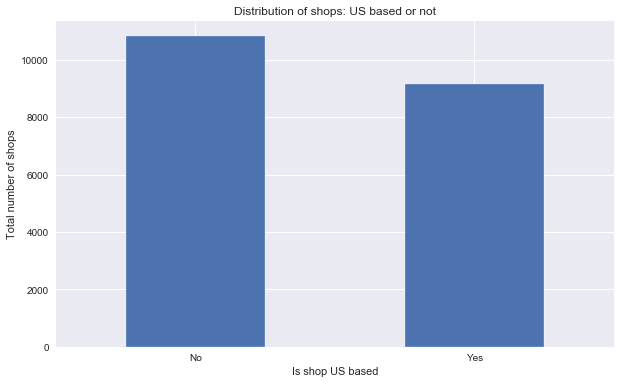

In [80]:
fig, ax = plt.subplots(1, figsize=(10,6))
plt.style.use('seaborn')

data.is_shop_us_based.value_counts().plot(kind='bar', rot=0)
plt.xlabel('Is shop US based')
plt.ylabel('Total number of shops')
plt.title('Distribution of shops: US based or not')

ticks = ['No', 'Yes']
ax.set_xticklabels(ticks)

plt.show()

Let's investigate the distribution of the active listings and the number of favorers (checking by the shop location: US based or not):

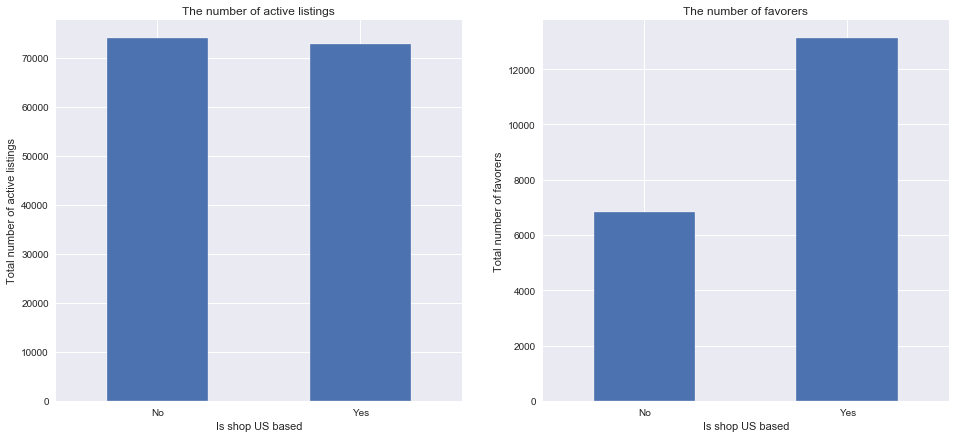

In [83]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,7)) #creating a figure with two charts
plt.style.use('seaborn')

plt.sca(ax1)

listings = data.groupby('is_shop_us_based')['listing_active_count'].sum()
listings.plot(kind='bar', rot=0)
plt.xlabel('Is shop US based')
plt.ylabel('Total number of active listings')
plt.title('The number of active listings')

ticks = ['No', 'Yes']
ax1.set_xticklabels(ticks)

plt.sca(ax2)

favorers = data.groupby('is_shop_us_based')['num_favorers'].sum()
favorers.plot(kind='bar', rot=0)
plt.xlabel('Is shop US based')
plt.ylabel('Total number of favorers')
plt.title('The number of favorers')

ticks = ['No', 'Yes']
ax2.set_xticklabels(ticks)

plt.show()

There is almost no difference in the number of active listings of the shops that are US based and not. But we can see a bigger difference in the total number of favorers. The US based shops have a clearly higher number of favorers.

Let's look at the correlation between the different variables by the shop location: US based or not

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in greater

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in less

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in greater

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in less

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in greater

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in less

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning:

invalid value encountered in greater

C:\Users\krist\Anaconda3\lib\site-packages\statsmodels\no

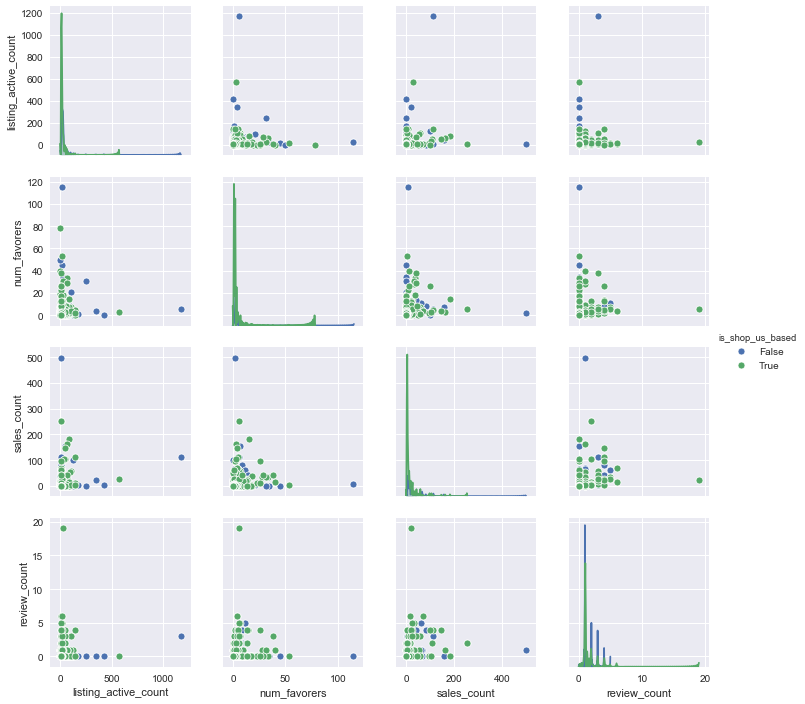

In [86]:
#taking the sample of the dataset

sns.pairplot(data[0:5000], vars=['listing_active_count', 'num_favorers', 'sales_count', 'review_count'], 
             hue="is_shop_us_based")

plt.show()

After briefly investigating the distribution of shops based on their location, let's check the distribution of sales per shop:

C:\Users\krist\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\krist\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



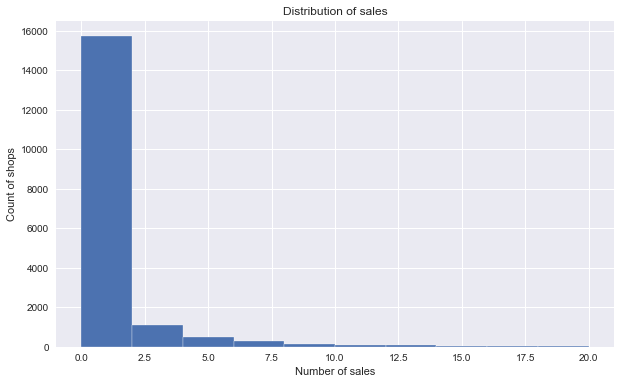

In [79]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn')

plt.hist(data.sales_count, range=(0,20)) #necessary to apply the range to see a clearer distribution
plt.xlabel('Number of sales')
plt.ylabel('Count of shops')
plt.title('Distribution of sales')
plt.show()

You can see that the majority of newly created shops have between 0 and 2,5 sales.

## Correlation

Let's check the correlation of all the dataset


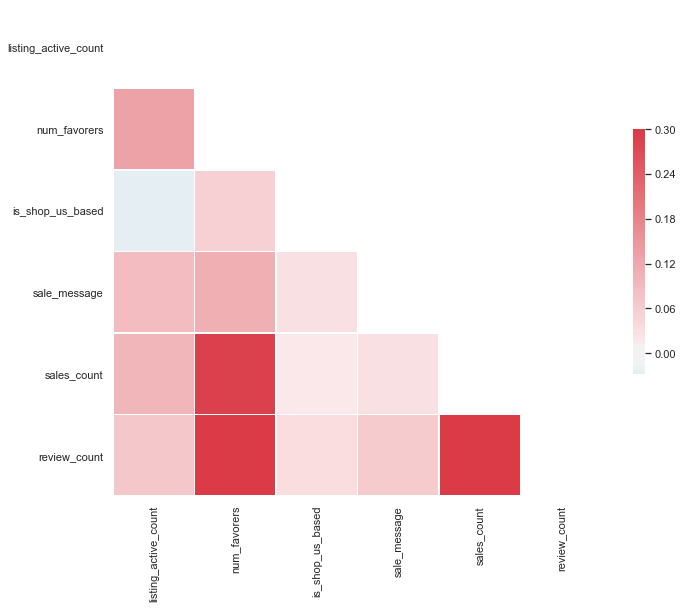

In [18]:

sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#the highest correlation can be seen between 
#the sales count and num favorers
#review count and num favorers and sales_count

#so the sales count is mostly correlated with review count and number of favorers.

In [19]:
#checking the actual % of correlation
corr = data.corr()
#filter matrix by one column: 
corr.sales_count.sort_values(ascending = False)

sales_count             1.000000
review_count            0.535855
num_favorers            0.286414
listing_active_count    0.097420
sale_message            0.028026
is_shop_us_based        0.016343
Name: sales_count, dtype: float64

In [20]:
data.head()

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0.0,0.0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2.0,0.0,NaN
2,19-Nov,0,0,USD,True,False,NaN,NaN,NaN
3,19-Nov,40,1,USD,False,False,0.0,0.0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0.0,0.0,"New York, United States"
